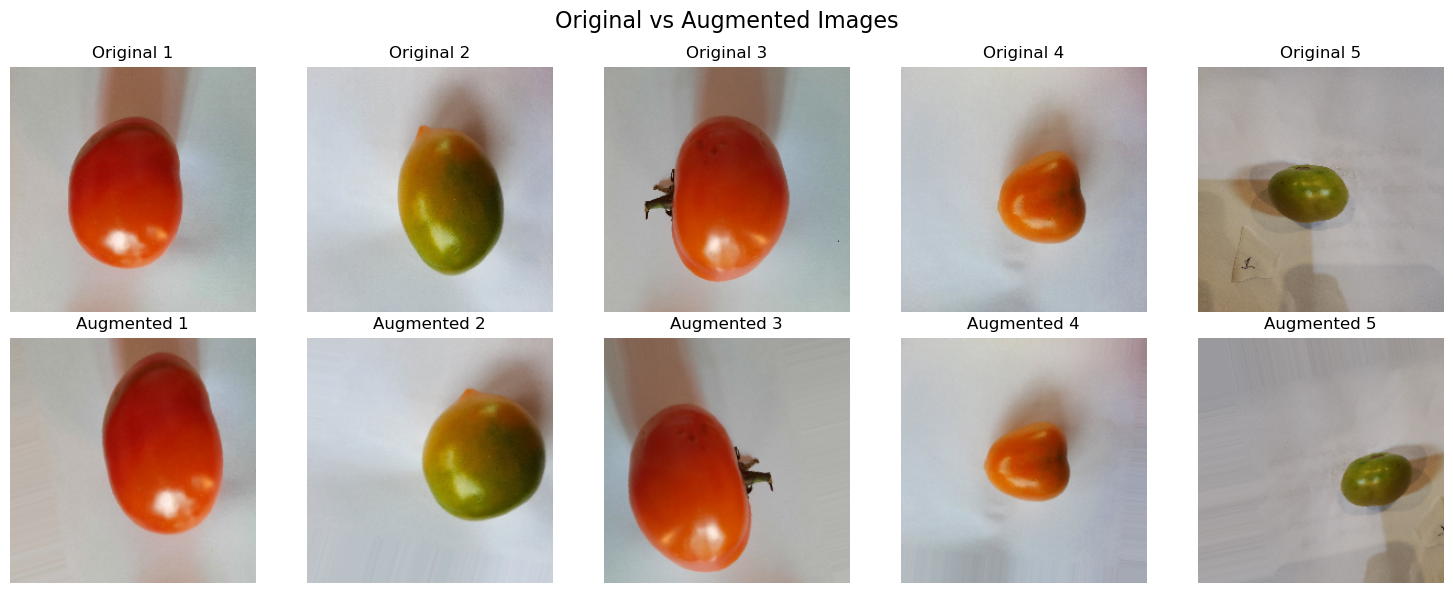

C:\Users\sarwa\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 682ms/step - accuracy: 0.4463 - loss: 1.9495 - val_accuracy: 0.5049 - val_loss: 0.9670
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 664ms/step - accuracy: 0.5197 - loss: 0.9601 - val_accuracy: 0.8447 - val_loss: 0.6273
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 661ms/step - accuracy: 0.6986 - loss: 0.6781 - val_accuracy: 0.8447 - val_loss: 0.4359
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 670ms/step - accuracy: 0.7253 - loss: 0.6086 - val_accuracy: 0.8447 - val_loss: 0.4212
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 665ms/step - accuracy: 0.8012 - loss: 0.4799 - val_accuracy: 0.8544 - val_loss: 0.3681
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 667ms/step - accuracy: 0.8760 - loss: 0.3878 - val_accuracy: 0.8738 - val_loss: 0.3419
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 665ms/step - accuracy: 0.8910 - loss: 0.3198 - val_accuracy: 0.9320 - val_loss: 0.2021
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 670ms/step - accuracy: 0.8872 - loss: 0.2792 - val_accuracy: 0

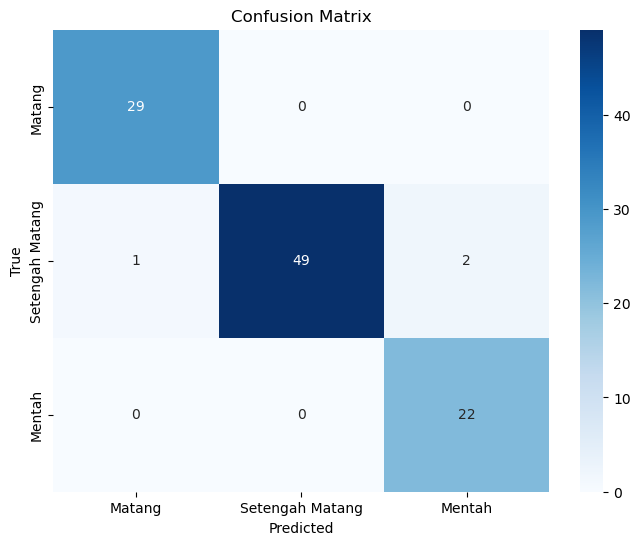

Model saved as 'tomato_maturity_model_with_augmentation.keras'


In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# **1. Memuat Dataset**
def load_dataset_from_folder(base_folder):
    folder_matang = os.path.join(base_folder, 'matang')
    folder_setengah_matang = os.path.join(base_folder, 'setengah_matang')
    folder_mentah = os.path.join(base_folder, 'mentah')

    def load_images(folder, label):
        images = []
        labels = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)
            try:
                img = load_img(img_path, target_size=(224, 224))  # Resize ke 224x224
                img_array = img_to_array(img) / 255.0  # Normalisasi
                images.append(img_array)
                labels.append(label)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
        return images, labels

    images_matang, labels_matang = load_images(folder_matang, 0)
    images_setengah_matang, labels_setengah_matang = load_images(folder_setengah_matang, 1)
    images_mentah, labels_mentah = load_images(folder_mentah, 2)

    images = np.array(images_matang + images_setengah_matang + images_mentah)
    labels = np.array(labels_matang + labels_setengah_matang + labels_mentah)
    return images, labels

# Path ke folder dataset
base_folder = 'dataset_tomat'
X, y = load_dataset_from_folder(base_folder)

# Konversi label ke one-hot encoding
y = to_categorical(y, num_classes=3)

# Membagi dataset menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# **2. Augmentasi Data**
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = data_gen.flow(X_train, y_train, batch_size=32)

# Visualisasi augmentasi dengan gambar asli
def visualize_augmentation_with_original(generator, images, num_samples=5):
    if len(images) == 0:
        print("No images available for visualization.")
        return
    
    plt.figure(figsize=(15, 6))
    for i in range(min(num_samples, len(images))):
        original_image = images[i]  # Gambar asli
        augmented_image = next(generator.flow(np.expand_dims(images[i], axis=0), batch_size=1))[0]  # Augmentasi
        
        # Menampilkan gambar asli
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(original_image)
        plt.axis('off')
        plt.title(f"Original {i+1}")
        
        # Menampilkan augmentasi
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(augmented_image)
        plt.axis('off')
        plt.title(f"Augmented {i+1}")
    
    plt.suptitle("Original vs Augmented Images", fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_augmentation_with_original(data_gen, X_train)

# **3. Membangun Model CNN**
model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Output untuk 3 kelas
])

# **4. Kompilasi Model**
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# **5. Melatih Model**
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=(X_test, y_test)
)

# **6. Mengevaluasi Model**
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

# **7. Analisis Hasil dengan Confusion Matrix**
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=['Matang', 'Setengah Matang', 'Mentah']))

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Matang', 'Setengah Matang', 'Mentah'], yticklabels=['Matang', 'Setengah Matang', 'Mentah'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# **8. Menyimpan Model**
model.save('tomato_maturity_model_with_augmentation.keras')
print("Model saved as 'tomato_maturity_model_with_augmentation.keras'")

Total images loaded: 22
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


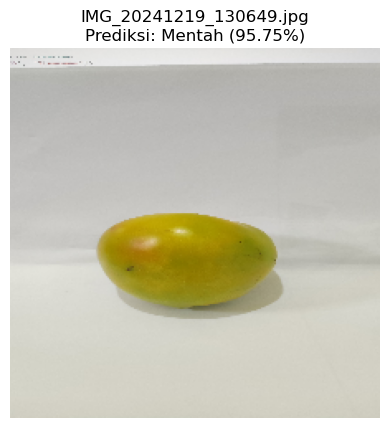

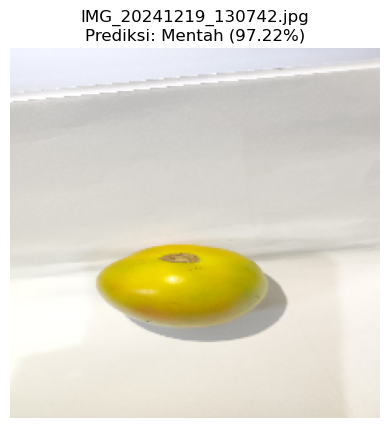

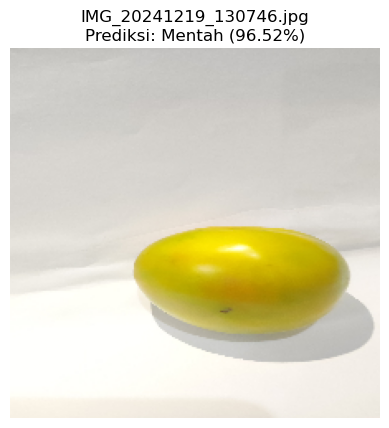

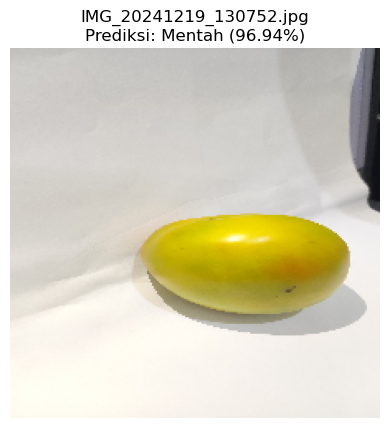

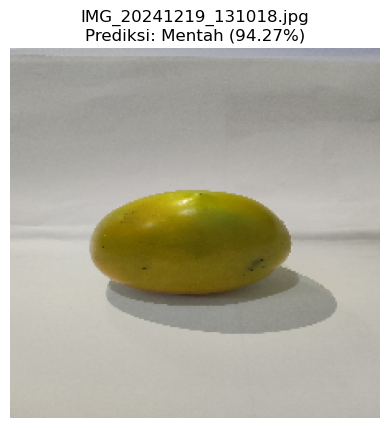

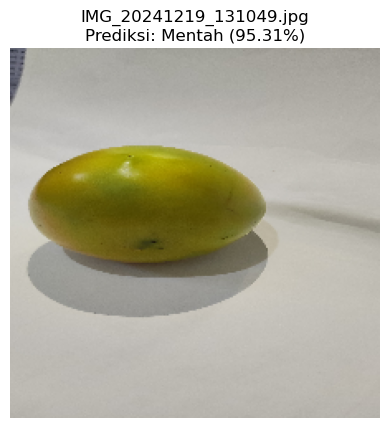

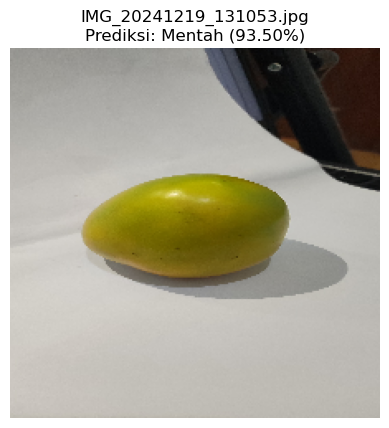

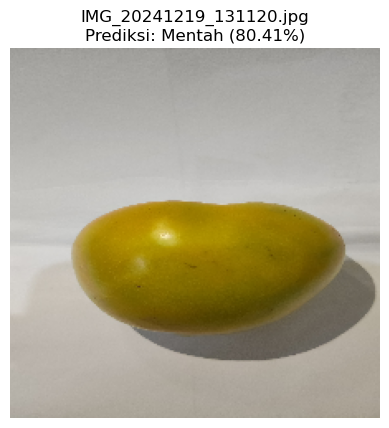

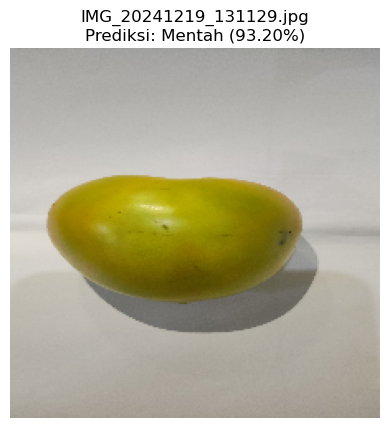

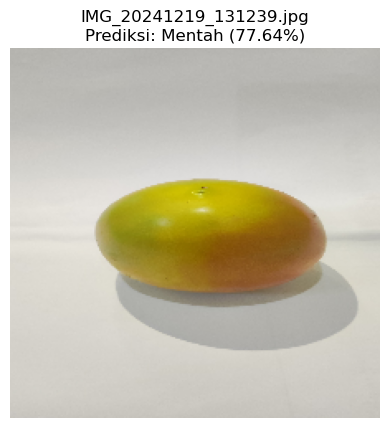

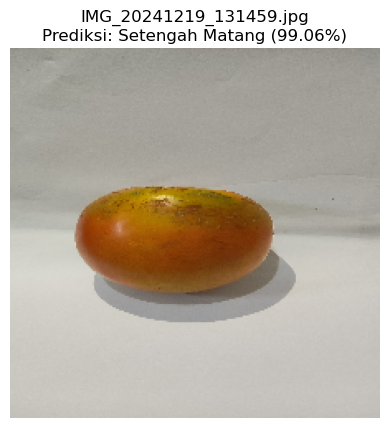

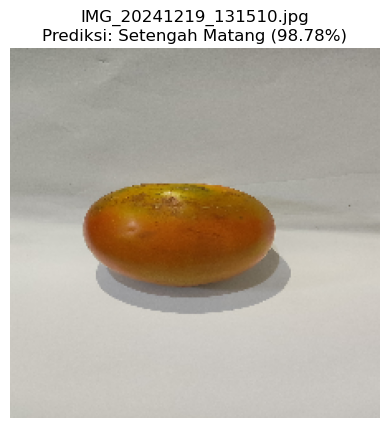

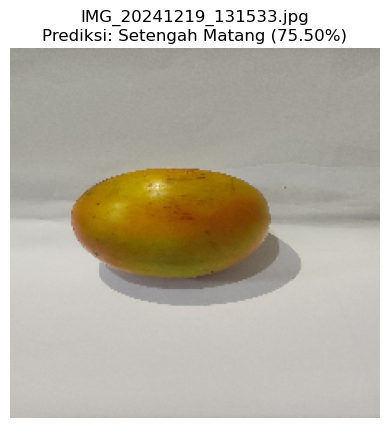

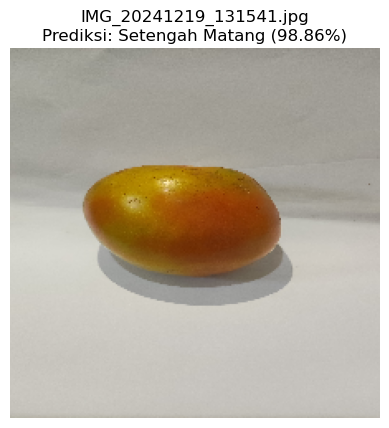

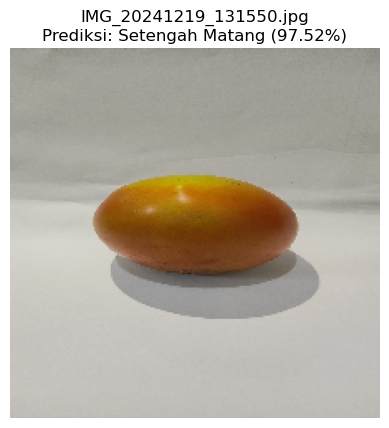

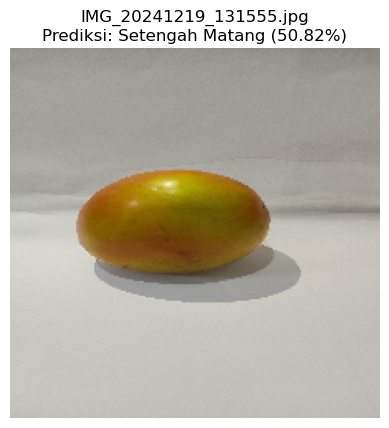

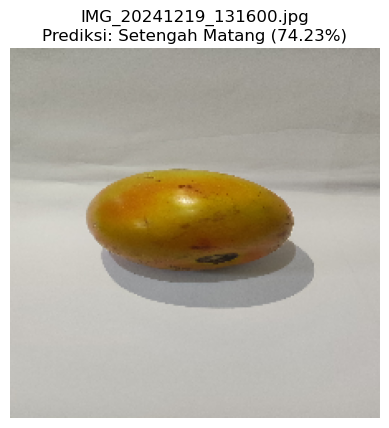

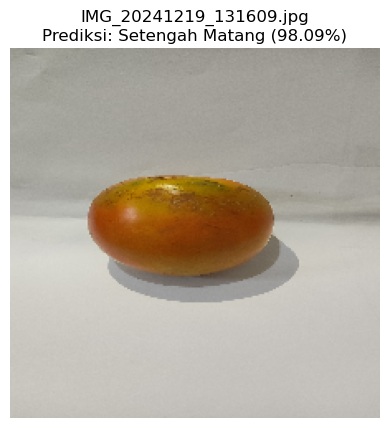

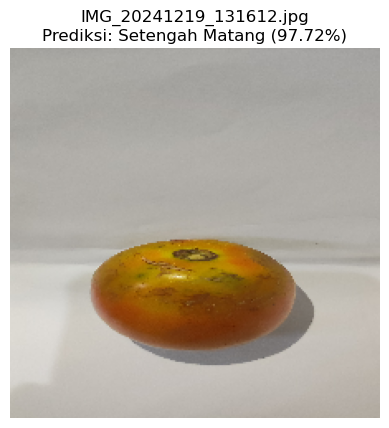

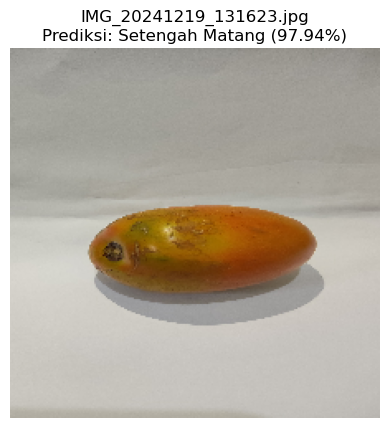

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# **1. Memuat Dataset Baru**
def load_new_dataset(folder_path, target_size=(224, 224)):
    images = []
    image_paths = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if filename.endswith((".jpg", ".png")):  # Validasi format file
            try:
                img = load_img(img_path, target_size=target_size)
                img_array = img_to_array(img) / 255.0  # Normalisasi
                images.append(img_array)
                image_paths.append(img_path)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    print(f"Total images loaded: {len(images)}")
    return np.array(images), image_paths

# **2. Memuat Model**
model_path = 'tomato_maturity_model_with_augmentation.h5'
model = load_model(model_path)

# **3. Prediksi Dataset Baru**
def predict_new_dataset(images, model):
    predictions = model.predict(images)
    return predictions

# **4. Visualisasi Hasil Prediksi**
def visualize_predictions(images, image_paths, predictions, labels, max_display=20):
    for i in range(min(len(images), max_display)):  # Batas maksimal tampilan
        predicted_label = labels[np.argmax(predictions[i])]
        confidence = np.max(predictions[i]) * 100

        plt.imshow(images[i])
        plt.axis('off')
        plt.title(f"{os.path.basename(image_paths[i])}\nPrediksi: {predicted_label} ({confidence:.2f}%)")
        plt.show()

# **5. Path ke Dataset Baru**
new_dataset_folder = 'dataset_tomat/test_prediksi'

# **6. Jalankan Pengujian**
labels = ['Matang', 'Setengah Matang', 'Mentah']
images, image_paths = load_new_dataset(new_dataset_folder)

if len(images) > 0:
    predictions = predict_new_dataset(images, model)
    visualize_predictions(images, image_paths, predictions, labels)
else:
    print("Dataset baru kosong atau tidak ada gambar valid!")